In [13]:
import os
import torch
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np

from detr_config import Config
from detr_dataset import get_test_dataset, detr_processor
from detr_model import DETRModel

In [14]:
model = DETRModel.load_from_checkpoint(
    './lightning_logs/queries=10_dmodel=64_layers=2/fold_1/checkpoints/epoch=35-step=180.ckpt'
)

## Detect

In [41]:
def plot_annotations(image, annotations):
    draw = ImageDraw.Draw(image, "RGB")
    id2label = model.detr_model.config.id2label

    for annotation in annotations:
        box = annotation['bbox']
        class_idx = annotation['category_id']
        x,y,w,h = tuple(box)
        draw.rectangle((x,y,x+w,y+h), outline='red', width=2)
        draw.text((x, y), id2label[class_idx], fill='black', 
                font=ImageFont.truetype("arial.ttf", 20))

    plt.figure(figsize=(3,3))
    plt.axis("off")
    plt.imshow(image)


def plot_results(image, results):
    scores, labels, boxes = results['scores'], results['labels'], results['boxes']

    draw = ImageDraw.Draw(image, "RGBA")
    id2label = model.detr_model.config.id2label

    for score, label, (x, y, xf, yf) in zip(scores.tolist(), labels.tolist(), boxes.tolist()):
        print(f'Score: {score}')
        draw.rectangle((x, y, xf, yf), outline='red', width=1)
        text = f'{np.round(score, 2)} - {id2label[label]}'
        draw.text((x, y), text, fill='red', 
                  font=ImageFont.truetype("arial.ttf", 18))

    plt.figure(figsize=(3,3))
    plt.axis("off")
    plt.imshow(image)

In [42]:
test_dataset = get_test_dataset()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [43]:
pixel_values, labels = test_dataset.__getitem__(5)
image_id = labels['image_id'].item()
image_data = test_dataset.coco.loadImgs(image_id)[0]

image = Image.open(os.path.join(Config.TEST_DIRECTORY, image_data['file_name']))
annotations = test_dataset.coco.imgToAnns[image_id]


with torch.no_grad():
    model.eval()
    outputs = model(pixel_values=pixel_values.unsqueeze(0))

postprocessed_outputs = detr_processor.post_process_object_detection(outputs,
                                                                     target_sizes=[(640, 640)],
                                                                     threshold=0.51,
                                                                     )
results = postprocessed_outputs[0]

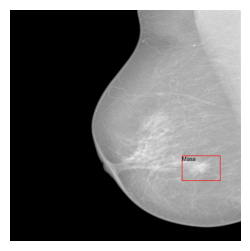

In [44]:
plot_annotations(image.copy(), annotations)


Score: 0.5268592834472656
Score: 0.5186219215393066
Score: 0.5197536945343018


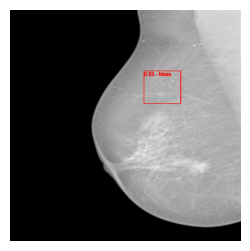

In [45]:
plot_results(image.copy(), results)